# Imports

In [111]:
import collections
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [112]:
# Random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for playback
_SAMPLING_RATE = 16000

# Collect data 

In [113]:
# Download the Maestro Dataset
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True, cache_dir='.', cache_subdir='data',
    )

In [114]:
# Find MIDI files
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of MIDI files:', len(filenames))

Number of MIDI files: 1282


In [115]:
# Let's parse and inspect one of the MIDI files
sample_file = filenames[1]
print(f'Sample MIDI file: {sample_file}')

Sample MIDI file: data/maestro-v2.0.0/2008/MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--1.midi


# Processing of a MIDI (.mid) File

In [116]:
# Generate a `PrettyMIDI` object
pm = pretty_midi.PrettyMIDI(sample_file)

def play_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

# Play the sample MIDI file
play_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


In [117]:
# Inspect the MIDI file's instrument information
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print(f'Instrument name: {instrument_name}')

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [118]:
# Convert MIDI into a DataFrame of musical notes
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [119]:
# Extract notes from the sample MIDI file
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,73,1.070312,1.372396,0.000000,0.302083
1,46,1.088542,1.846354,0.018229,0.757812
2,72,1.277344,1.494792,0.188802,0.217448
3,70,1.484375,1.652344,0.207031,0.167969
4,69,1.673177,1.820312,0.188802,0.147135


# Visualize the Data

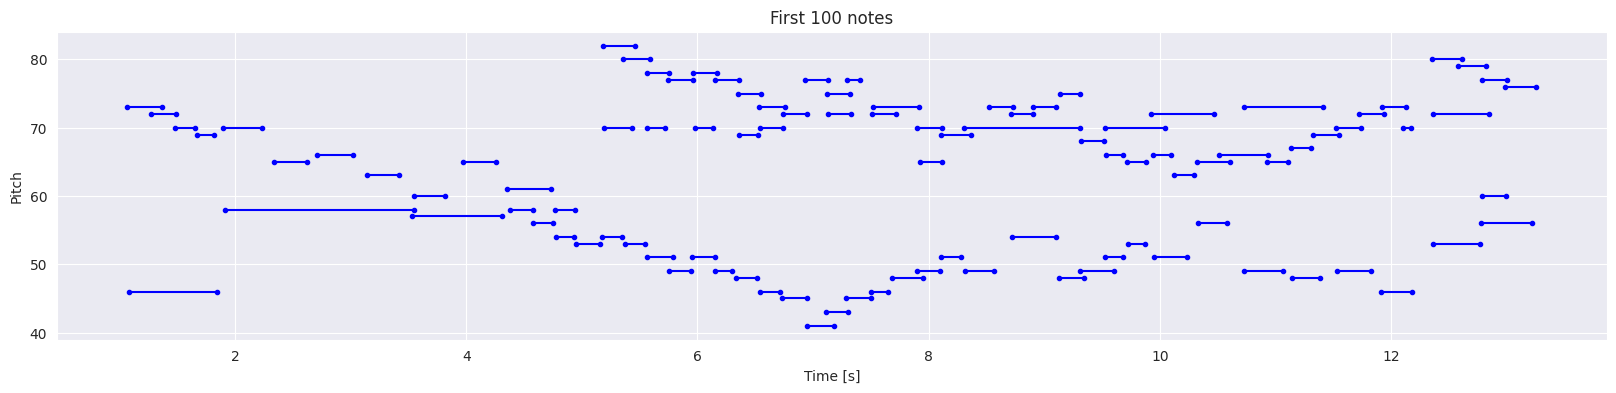

In [120]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])

    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

# Plot the first 100 notes
plot_piano_roll(raw_notes, count=100)

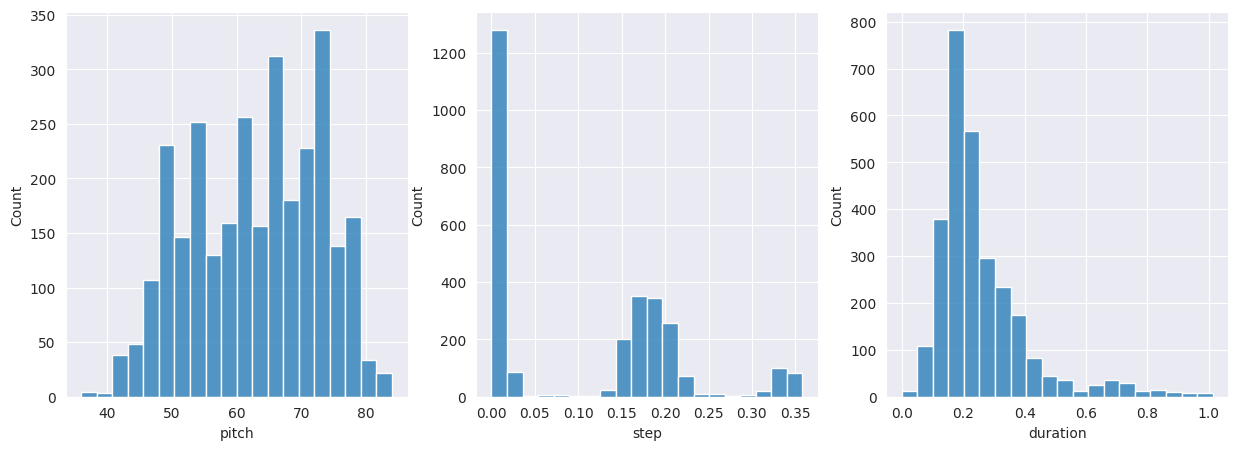

In [121]:
# Plot note distributions (pitch, step, and duration)
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

# Plot the distributions of note variables
plot_distributions(raw_notes)

# Preprocess the Data

In [122]:
# Stack the notes into sequences for model training
def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size=128) -> tf.data.Dataset:
    seq_length += 1
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]
        return x

    def split_labels(sequences):
        # Split into input and labels - the label is the last item in the sequence
        inputs = sequences[:-1]  # Everything but the last step is the input
        labels = sequences[-1]  # Last step is the label
        labels_pitch = labels[0]  # Pitch labels as the first dimension
        return scale_pitch(inputs), {'pitch': labels_pitch, 'step': labels[1], 'duration': labels[2]}

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [123]:
# Create sequences for model training
seq_length = 25
vocab_size = 128
train_notes = np.stack([raw_notes[key] for key in ['pitch', 'step', 'duration']], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

# Build and Train the Model

In [124]:
# LSTM model to generate music
def mse_with_positive_pressure(y_true, y_pred):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [125]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

In [126]:
outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

In [127]:
# Define custom loss functions and optimizer
loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

In [128]:
# Summarize the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 128)                  67584     ['input_5[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_4[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_4[0][0]']              
                                                                                            

# Train the Model

In [129]:
# Define callbacks for checkpointing and early stopping
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}', save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

# Train the model for a specified number of epochs
epochs = 200
history = model.fit(seq_ds.batch(64).shuffle(1000).cache().prefetch(tf.data.experimental.AUTOTUNE), epochs=epochs, callbacks=callbacks)

Epoch 1/200
46/46 [==============================] - 2s 14ms/step - loss: 4.1955 - duration_loss: 0.1327 - pitch_loss: 3.8922 - step_loss: 0.1706
Epoch 2/200
46/46 [==============================] - 1s 13ms/step - loss: 3.6568 - duration_loss: 0.1272 - pitch_loss: 3.5033 - step_loss: 0.0263
Epoch 3/200
46/46 [==============================] - 1s 13ms/step - loss: 3.6403 - duration_loss: 0.1245 - pitch_loss: 3.4915 - step_loss: 0.0242
Epoch 4/200
46/46 [==============================] - 1s 13ms/step - loss: 3.6339 - duration_loss: 0.1226 - pitch_loss: 3.4873 - step_loss: 0.0240
Epoch 5/200
46/46 [==============================] - 1s 13ms/step - loss: 3.6287 - duration_loss: 0.1214 - pitch_loss: 3.4836 - step_loss: 0.0238
Epoch 6/200
46/46 [==============================] - 1s 13ms/step - loss: 3.6243 - duration_loss: 0.1205 - pitch_loss: 3.4802 - step_loss: 0.0235
Epoch 7/200
46/46 [==============================] - 1s 13ms/step - loss: 3.6202 - duration_loss: 0.1196 - pitch_loss: 3.477

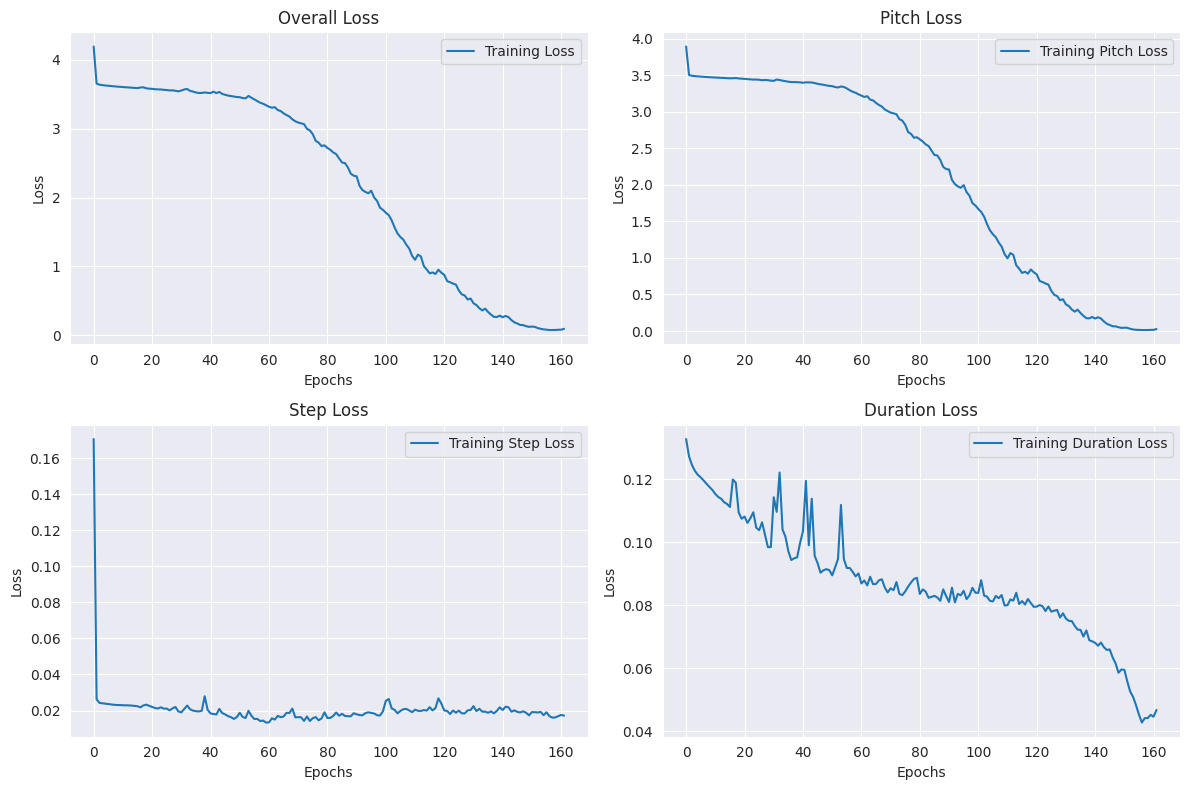

In [130]:
history_dict = history.history

# Plot the overall loss
plt.figure(figsize=(12, 8))

# Overall loss
plt.subplot(2, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
if 'val_loss' in history_dict:
    plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Overall Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Pitch loss
plt.subplot(2, 2, 2)
plt.plot(history_dict['pitch_loss'], label='Training Pitch Loss')
if 'val_pitch_loss' in history_dict:
    plt.plot(history_dict['val_pitch_loss'], label='Validation Pitch Loss')
plt.title('Pitch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Step loss
plt.subplot(2, 2, 3)
plt.plot(history_dict['step_loss'], label='Training Step Loss')
if 'val_step_loss' in history_dict:
    plt.plot(history_dict['val_step_loss'], label='Validation Step Loss')
plt.title('Step Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Duration loss
plt.subplot(2, 2, 4)
plt.plot(history_dict['duration_loss'], label='Training Duration Loss')
if 'val_duration_loss' in history_dict:
    plt.plot(history_dict['val_duration_loss'], label='Validation Duration Loss')
plt.title('Duration Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate New Music

In [131]:
# Predict and generate new music based on the trained model
def predict_next_note(notes, model, temperature=1.0):
    assert temperature > 0
    inputs = tf.expand_dims(notes, 0)
    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)

    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [132]:
# Generate a sequence of new notes
temperature = 2.0
num_predictions = 120

input_notes = train_notes[:seq_length] / [vocab_size, 1, 1]
generated_notes = []

In [133]:
def notes_to_midi(
        notes: pd.DataFrame,
        out_file: str,
        instrument_name: str,
        velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [134]:
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    generated_notes.append((pitch, start, end))

    new_note = (pitch, step, duration)
    input_notes = np.concatenate([input_notes[1:], np.expand_dims(new_note, 0)], axis=0)
    prev_start = start

# Convert the generated notes back into a MIDI file and play
generated_notes = pd.DataFrame(generated_notes, columns=['pitch', 'start', 'end'])
generated_notes.head()

1/1 [==============================] - 0s 12ms/step


,pitch,start,end
0,78,0.148196,0.582945
1,77,0.301576,0.655418
2,80,0.481878,0.892602
3,53,0.662438,1.084450
4,53,0.824029,1.175431


In [135]:
generated_notes['step'] = generated_notes['start'].diff().fillna(0)
generated_notes['duration'] = generated_notes['end'] - generated_notes['start']
generated_pm = notes_to_midi(generated_notes, out_file="output.mid", instrument_name="Acoustic Grand Piano")

In [136]:
play_audio(generated_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
